# Informações ao avaliador:
#### Quais as principais características da base de dados
- Há muitos outliers em toda a distribuição (ver EDA), 
- A base é facilmente agrupável e de entidades normalizadas, 
- A base está dividida em 3 categorias:
    - Registros de atividades dos estudantes;
    - Base de cursos e provas realizadas;
    - Demografia e informações dos estudantes 

#### Problema de negócio
Prever nota (score) por regressão.
- Como? Utilizando das principais informações socioeconômicas, demográficas, tipo de teste e engajamento de cliques do estudante para prever a nota.

#### Modelo utilizado
RandomForestRegressor
- Motivo: por ser do médoto ensemble, lida bem com variáveis mistas (numéricas e categóricas)

#### Como avalio os resultados
O modelo de baseline conseguiu identificar de forma adequada os valores de provas deixadas em branco e errou em erro médio absoluto aproximadamente 10 pontos entre valores verdadeiros e preditos.  
O modelo pode ser facilmente melhorado em novas iterações utilizando feature selection, algumas das variáveis não pesaram no critério de decisão da Random Forest (ver Resultados).


Segue código da solução.

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts 
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler

## Importando o conjunto de dados

In [2]:
# ! wget https://analyse.kmi.open.ac.uk/open_dataset/download --no-check-certificate && mv download download.zip && unzip download.zip && rm download.zip

In [3]:
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
student_assessment = pd.read_csv('studentAssessment.csv')
student_info = pd.read_csv('studentInfo.csv')
student_registration = pd.read_csv('studentRegistration.csv')
student_vle = pd.read_csv('studentVle.csv')
vle = pd.read_csv('vle.csv')

## Unificando as bases de dados

In [4]:
student_vle_grouped = student_vle.groupby(['id_student', 'code_module', 'code_presentation']).sum().drop(columns=['id_site', 'date'])
student_vle_grouped.head(2)

sum_click
id_student code_module code_presentation           
6516       AAA         2014J                   2791
8462       DDD         2013J                    646

In [5]:
student_info_vle = pd.merge(student_info, student_vle_grouped, how='left', left_on=('id_student', 'code_module', 'code_presentation'), right_on=('id_student', 'code_module', 'code_presentation'))
student_info_vle.head(2)

code_module code_presentation  id_student gender               region  \
0         AAA             2013J       11391      M  East Anglian Region   
1         AAA             2013J       28400      F             Scotland   

  highest_education imd_band age_band  num_of_prev_attempts  studied_credits  \
0  HE Qualification  90-100%     55<=                     0              240   
1  HE Qualification   20-30%    35-55                     0               60   

  disability final_result  sum_click  
0          N         Pass      934.0  
1          N         Pass     1435.0

In [6]:
student_assessment_assessment = pd.merge(assessments, student_assessment, how='left', left_on=('id_assessment'), right_on=('id_assessment'))
student_assessment_assessment.head(2)

code_module code_presentation  id_assessment assessment_type  date  weight  \
0         AAA             2013J           1752             TMA  19.0    10.0   
1         AAA             2013J           1752             TMA  19.0    10.0   

   id_student  date_submitted  is_banked  score  
0     11391.0            18.0        0.0   78.0  
1     28400.0            22.0        0.0   70.0

In [7]:
info_vle_assessment = pd.merge(student_info_vle, student_assessment_assessment, how='left', left_on=('id_student', 'code_module', 'code_presentation'), right_on=('id_student', 'code_module', 'code_presentation'))
info_vle_assessment.head(2)

code_module code_presentation  id_student gender               region  \
0         AAA             2013J       11391      M  East Anglian Region   
1         AAA             2013J       11391      M  East Anglian Region   

  highest_education imd_band age_band  num_of_prev_attempts  studied_credits  \
0  HE Qualification  90-100%     55<=                     0              240   
1  HE Qualification  90-100%     55<=                     0              240   

  disability final_result  sum_click  id_assessment assessment_type  date  \
0          N         Pass      934.0         1752.0             TMA  19.0   
1          N         Pass      934.0         1753.0             TMA  54.0   

   weight  date_submitted  is_banked  score  
0    10.0            18.0        0.0   78.0  
1    20.0            53.0        0.0   85.0

In [8]:
aux = pd.merge(info_vle_assessment, student_registration, how='left', left_on=('id_student', 'code_module', 'code_presentation'), right_on=('id_student', 'code_module', 'code_presentation'))
aux.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'sum_click',
       'id_assessment', 'assessment_type', 'date', 'weight', 'date_submitted',
       'is_banked', 'score', 'date_registration', 'date_unregistration'],
      dtype='object')

### Salvando o conjunto de dados

In [9]:
aux.to_csv('oula.csv', header=True, index_label=False)

### Carregando o conjunto de dados

In [10]:
df = pd.read_csv('oula.csv')

# EDA

### Qual é a nota média dos estudantes por teste?

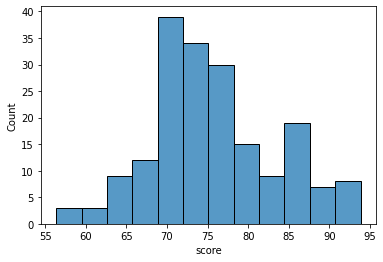

In [11]:
sns.histplot(df.groupby('id_assessment')['score'].mean());

### Quantos testes em média os estudantes realizam?

In [12]:
df.groupby('id_student').count()['id_assessment'].mean()

6.041757859996526

- Com uma média tão baixa de registros, não conseguiremos utilizar métodos de análise de série temporal mais sofisticados como VAR ou VARIMA

### Verificando como se comportam as notas de estudantes que utilizaram nota previamente armazenada (id_banked = 1)

In [13]:
print('número de notas reutilizadas:', df[df.is_banked == 1]['is_banked'].sum())

número de notas reutilizadas: 1909.0


## Como é o perfil dos estudantes com notas reutilizadas?

In [14]:
students_with_banked_scores = df[df.is_banked == 1]['id_student'].unique()

In [15]:
df[df.id_student == students_with_banked_scores[2]][['id_student', 'is_banked', 'score']]

id_student  is_banked  score
189       129955        0.0   85.0
190       129955        0.0   82.0
191       129955        0.0   76.0
1795      129955        1.0   85.0
1796      129955        1.0   82.0
1797      129955        1.0   76.0

- is_banked pode ser utilizada para substituir com exatidão a nota de estudantes
- a flag date_submitted -1 indica uso de is_banked, podemos usar qualquer um dos dois pra sinalizar o uso de nota anterior
- o valor da nota do estudante ao utilizar is_banked será a primeira nota registrada e assim em diante (score em t+0)

## PROBLEMA DE NEGÓCIO: Como predizer o desempenho dos estudantes nas avaliações finais?

In [16]:
def score_comparison(by):
  sns.boxplot(x=df[by].values, y=df['score'], palette='Blues')
  plt.xticks(rotation=45)
  plt.title(f'Comparação das notas para {by}')
  plt.show()

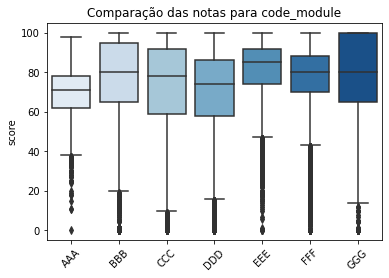

In [17]:
score_comparison('code_module')

- Grande variabilidade, cada modulo tem um alcance de notas distinto. Será uma feature muito importante para nosso modelo!

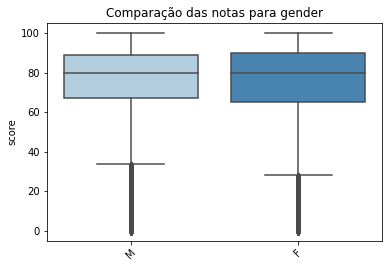

In [18]:
score_comparison('gender')

- Inconclusivo, há pouca diferença entre categorias

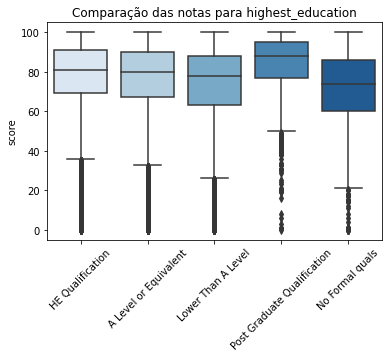

In [19]:
score_comparison('highest_education')

- Quanto maior é o grau de estudo, maior é a nota média dos estudantes.

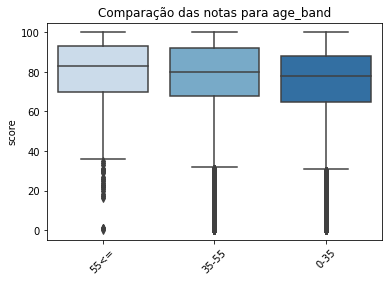

In [20]:
score_comparison('age_band')

- Inconclusivo, há pouca diferença entre categorias

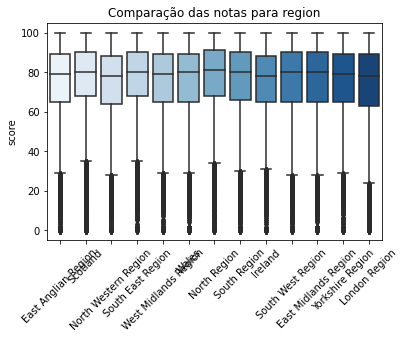

In [21]:
score_comparison('region')

- Inconclusivo, há pouca diferença entre categorias

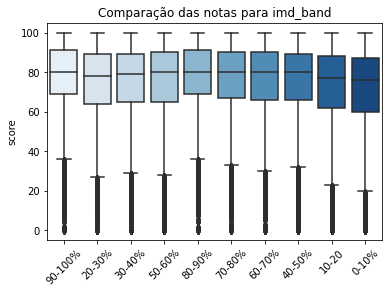

In [22]:
score_comparison('imd_band')

- Quanto menor é o índice de deprivação (IMD) menor é a nota média do estudante

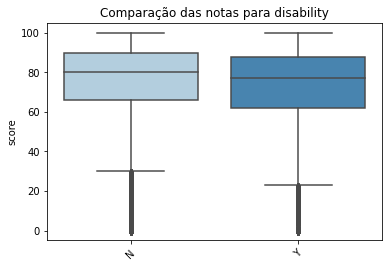

In [23]:
score_comparison('disability')

- Aparentemente PNEs possuem nota média inferior, porém não vamos utilizar isso como classificador em nosso modelo. Além disso, a diferença é pequena

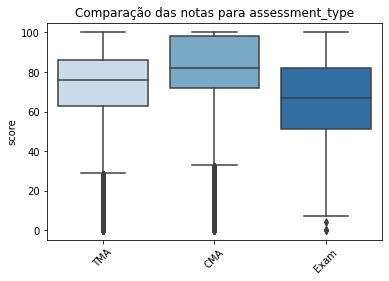

In [24]:
score_comparison('assessment_type')

- Bastante diferença entre notas para cada um dos teste, verificamos que os testes de treino (Exam) recebem uma nota ligeiramente menor que as demais provas

# ML

## Feature Engineering
- Vamos criar um campo binário que aponta se um estudante desistiu do curso (contém date_unregistration)

In [25]:
df['unregistered'] = df['date_unregistration'].notnull()

## Seleção de Features do Modelo de Baseline
- Vamos utilizar como features iniciais as variáveis que obtiveram as melhores notas em correlação, tanto positiva quanto negativa
- Vamos utilizar o campo *id_student*, pois se for requisitada nova nota de um estudante já existente na base, o modelo já terá conhecimento prévio de notas anteriores daquele estudante.

In [26]:
df.corr(method='pearson')['score'].drop(index='score').sort_values(ascending=False)

sum_click               0.188467
date                    0.078527
id_assessment           0.072495
id_student              0.024149
date_registration       0.017996
date_unregistration     0.014398
is_banked              -0.008149
date_submitted         -0.033893
studied_credits        -0.047556
num_of_prev_attempts   -0.065964
unregistered           -0.146550
weight                 -0.166416
Name: score, dtype: float64

In [27]:
df.corr(method='spearman')['score'].drop(index='score').sort_values(ascending=False)

sum_click               0.194984
date                    0.074814
id_assessment           0.059582
id_student              0.048362
date_registration       0.016716
date_unregistration    -0.005155
is_banked              -0.012915
date_submitted         -0.040422
studied_credits        -0.055049
num_of_prev_attempts   -0.070041
unregistered           -0.123670
weight                 -0.199866
Name: score, dtype: float64

In [28]:
X = df.drop(columns=['score', 'gender', 'region', 'date', 'disability'])
y = df['score']

X_prep = X.apply(lambda x: x.replace(np.nan, 0))
y_prep = y.fillna(0)

## Pré processamento


### Encoding
- Vamos encodar numericamente os estudantes em ordem de aparição, os campos de resultados finais e tipo de prova

In [29]:
enc = LabelEncoder()

X_prep['id_student'] = enc.fit_transform(X_prep['id_student'])
X_prep['code_presentation'] = enc.fit_transform(X_prep['code_presentation'])

X_prep = pd.get_dummies(X_prep, columns=['final_result', 'assessment_type', 'highest_education', 'imd_band', 'code_module', 'age_band'], drop_first=True)

X_train, X_test, y_train, y_test = tts(X_prep, y_prep, train_size=0.7)

### Scaling
- Vamos utilizar um scaler robusto a outliers, porque verificamos pela EDA a existência de muitos outliers em nosso dataset

In [30]:
rs = RobustScaler()

rs.fit(X_train)
X_train_scaled = rs.transform(X_train)
X_test_scaled = rs.transform(X_test)

## Treinamento do Modelo
- Utilizaremos um método de ensemble, que é facilmente ajustável a features mistas (numéricas, categóricas)

In [31]:
rf = RandomForestRegressor(criterion='mse', max_depth=15, random_state=42, n_jobs=-1)

rf.fit(X_train_scaled, y_train)
results = rf.predict(X_test_scaled)

# Resultados

## Features por importância

In [32]:
[[round(i, 5), j] for (i, j) in zip(rf.feature_importances_, X_train.columns)]

[[0.00401, 'code_presentation'],
 [0.03258, 'id_student'],
 [0.00384, 'num_of_prev_attempts'],
 [0.0087, 'studied_credits'],
 [0.06481, 'sum_click'],
 [0.5491, 'id_assessment'],
 [0.04203, 'weight'],
 [0.06229, 'date_submitted'],
 [0.00022, 'is_banked'],
 [0.02883, 'date_registration'],
 [0.00989, 'date_unregistration'],
 [0.00077, 'unregistered'],
 [0.05829, 'final_result_Fail'],
 [0.03289, 'final_result_Pass'],
 [0.02104, 'final_result_Withdrawn'],
 [0.03285, 'assessment_type_CMA'],
 [8e-05, 'assessment_type_Exam'],
 [0.00244, 'assessment_type_TMA'],
 [0.00263, 'highest_education_HE Qualification'],
 [0.00402, 'highest_education_Lower Than A Level'],
 [0.00134, 'highest_education_No Formal quals'],
 [0.00055, 'highest_education_Post Graduate Qualification'],
 [0.00326, 'imd_band_0-10%'],
 [0.00265, 'imd_band_10-20'],
 [0.00222, 'imd_band_20-30%'],
 [0.00221, 'imd_band_30-40%'],
 [0.00204, 'imd_band_40-50%'],
 [0.00225, 'imd_band_50-60%'],
 [0.00181, 'imd_band_60-70%'],
 [0.00186, 'im

### Como está a previsão do modelo?

In [33]:
prediction = pd.DataFrame()
prediction['results'] = list(results)
prediction['true'] = list(y_test)

In [34]:
print('Taxa de erros em previsão de nulos:')
sum(sum([prediction[prediction['true'] == 0]['results'] != 0])) / prediction.shape[0]

Taxa de erros em previsão de nulos:


0.0024908208638535767

- O modelo está prevendo valores nulos corretamente! (Utilizando *assessment_type*)

### Distribuição de valores verdadeiros x preditos

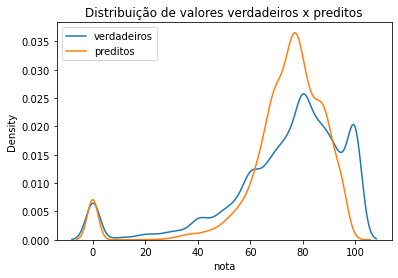

In [35]:
sns.kdeplot(prediction.true)
sns.kdeplot(prediction.results)
plt.legend(['verdadeiros', 'preditos'])
plt.xlabel('nota')
plt.title('Distribuição de valores verdadeiros x preditos');

- A média de valores verdadeiros se aproxima da média dos valores preditos, porém o modelo tem dificuldade em prever notas acima de 90 pontos e está aparentemente enviesado entre 65-75 (picos)

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
pd.DataFrame({
    'mse': mean_squared_error(y_test, results, squared=False),
    'mae': mean_absolute_error(y_test, results),
    'evar': explained_variance_score(y_test, results)
}, index=[0])

mse        mae      evar
0  14.648758  10.627565  0.606893

### O quanto o modelo está errando em relação aos valores verdadeiros?

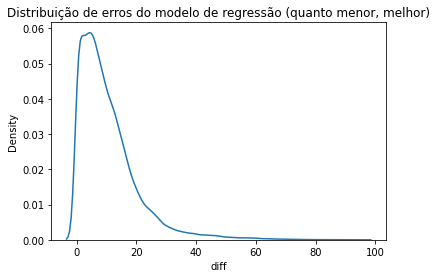

In [37]:
prediction['diff'] = abs(prediction.true - prediction.results)
sns.kdeplot(prediction['diff'])
plt.title('Distribuição de erros do modelo de regressão (quanto menor, melhor)');

## Escolhendo as melhores features com o feature selection

In [38]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.ensemble import RandomForestRegressor

# # Feature Selection
# k_vs_score=[]
# seed = 42

# for k in range(2, X_train.shape[1], 2):
#     # selector_model = LinearRegression(normalize=True)
#     # selector_model = Ridge(alpha=0.1, normalize=True, random_state=seed)
#     selector_model = Lasso(alpha=1.,normalize=True, random_state=seed)
#     # selector_model = RandomForestRegressor(criterion='mse', random_state=seed, n_jobs=-1)

#     selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)
    
#     selector.fit(X_train_scaled, y_train)
#     X_train_2 = selector.transform(X_train)

#     X_test_2 = selector.transform(X_test_scaled)

#     model = RandomForestRegressor(criterion='mse', n_estimators=100, random_state=seed, n_jobs=-1, max_depth=9)
#     model.fit(X_train_2, y_train)

#     p = model.predict(X_test_2)

#     score = explained_variance_score(y_test, p)
#     print(f"k = {k}; EVAR = {score}")

#     mask = selector.get_support()
#     print(X_train.columns[mask])
#     k_vs_score.append(score)

## Reprodutibilidade

In [39]:
! pip freeze > requirements.txt

In [41]:
! jupyter nbconvert oula.ipynb --to markdown --output README.md

[NbConvertApp] Converting notebook oula.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory R